### Read ECS and HS data and plot

In [1]:
import csv
import sys
import os
import datetime

%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats

import pandas as pd

from matplotlib import patches as pa


### To compare calculations dropping the first 20 years of abrupt-4xCO2:
Replace all instances of the function remove_drift with remove_drift_and_20

In [2]:
def remove_drift_and_20(ds_modvariant_variable):
    # should have 2 experiments and 150 times
 
    y_pi_annual = ds_modvariant_variable.sel(experiment=("piControl"))
    y_4x_annual = ds_modvariant_variable.sel(experiment=("abrupt_4xCO2")) # why not abrupt-4xCO2???

    x = range(len(y_4x_annual))
    #x_pi = x
    model = modvar.split("_")[0]
    x = range(len(y_4x_annual))
    if model=="EC-Earth3" or model=="IITM-ESM":
        print("fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end")
        print("current model: "+model)
        y_pi_annual_nan = y_pi_annual.dropna(dim="time")
        x_pi = x[(len(x)-len(y_pi_annual_nan)):]
    else: 
        x_pi = x
        y_pi_annual_nan = y_pi_annual
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_pi,y_pi_annual_nan)
    dy = y_4x_annual-(intercept + slope*x)
    
    if len(dy)<150:
        print("  --- WARNING: Fix remove_drift for drop20 to work ",len(dy)," ---")
    dy = dy[20:]
    
    return dy

In [3]:
def remove_drift(ds_modvariant_variable):
    # should have 2 experiments and 150 times
 
    y_pi_annual = ds_modvariant_variable.sel(experiment=("piControl"))
    y_4x_annual = ds_modvariant_variable.sel(experiment=("abrupt_4xCO2")) # why not abrupt-4xCO2???

    x = range(len(y_4x_annual))
    #x_pi = x
    model = modvar.split("_")[0]
    x = range(len(y_4x_annual))
    if model=="EC-Earth3" or model=="IITM-ESM":
        print("fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end")
        print("current model: "+model)
        y_pi_annual_nan = y_pi_annual.dropna(dim="time")
        x_pi = x[(len(x)-len(y_pi_annual_nan)):]
    else: 
        x_pi = x
        y_pi_annual_nan = y_pi_annual
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_pi,y_pi_annual_nan)
    dy = y_4x_annual-(intercept + slope*x)
    
    return dy

In [4]:
def match_data(models_variants, modvar_data):
    #modvar_data = FECS.copy()
    mod_data = {}
    for model in list(models_variants):
        try:
            arr = [item for key,item in modvar_data[model].items()]    
            mod_data[model]=np.mean(arr,0)
        except:
            mod_data[model] = np.nan
    return mod_data

In [7]:
def precip_lists_to_arrays(data,models):
    #[dp_d,dpdT,p_pi,intercept_d,intercept,thedpr_d,thedpr,thedt]
    # result will be [ type ]
    #       types - 0: drift removed, 1: mean pi removed, 2: mean pi 
    array = np.zeros([len(models),3])*np.nan
    ints = np.zeros([len(models),2])*np.nan
    dp = np.zeros([len(models),2])*np.nan
    dt = np.zeros([len(models)])*np.nan
    for imod in range(len(models)):
        model=models[imod]
        try:
            array[imod,0]=data[model][0]
            array[imod,1]=data[model][1]
            array[imod,2]=data[model][2]
            ints[imod,0]=data[model][3]
            ints[imod,1]=data[model][4]
            dp[imod,0]=data[model][5]
            dp[imod,1]=data[model][6]
            dt[imod]=data[model][7]
        except:
            dt[imod]=np.nan
    return array,ints,dp,dt

In [8]:
def flux_lists_to_arrays(fluxes,models):
    #[dSWutdT_d,dOLRdT_d,dNutdT_d,dSWutdT,dOLRdT,dNutdT,dSWut_pi,dOLR_pi,Nut_pi]
    #[dSWdsdT_d,dLWdsdT_d,dNdsdT_d,dSWdsdT,dLWdsdT,dNdsdT,dSWds_pi,dLWds_pi,Nds_pi]
    # result will be [wavelength,type]
    #   wavelengths - 0: SW, 1: LW, 2: Net
    #         types - 0: drift removed, 1: mean pi removed, 2: mean pi 
    # Sign convention: positive is more precip (TOA: positive up) (SFC: positive down)
    array = np.zeros([len(models),3,3])*np.nan
    for imod in range(len(models)):
        model=models[imod]
        array[imod,0,0]=fluxes[model][0]
        array[imod,1,0]=fluxes[model][1]
        array[imod,2,0]=fluxes[model][2]
        array[imod,0,1]=fluxes[model][3]
        array[imod,1,1]=fluxes[model][4]
        array[imod,2,1]=fluxes[model][5]
        array[imod,0,2]=fluxes[model][6]
        array[imod,1,2]=fluxes[model][7]
        array[imod,2,2]=fluxes[model][8]
    return array 

## Load data and determine which models and variants we have all the data for 

In [9]:
datestamp="14052020"

In [10]:
ds = xr.open_dataset("data/ecs_timeseries_"+datestamp+".nc")

In [12]:
model_variants = list(ds.model_variant.values)

In [14]:
ds2 = xr.open_dataset("data/otherflux_timeseries_"+datestamp+".nc")

In [15]:
vars2 = [var for var in list(ds2.variables) if var not in list(ds2.coords)]

In [16]:
### bespoke fix: rldscs has the wrong sign for this variable in one model; fix it
i_iitm = list(ds2.model_variant).index("IITM-ESM_r1i1p1f1")

In [18]:
ds2.rldscs[i_iitm,:,:] = -1*ds2.rldscs[i_iitm,:,:]

In [19]:
for modvar in model_variants:
    if modvar not in list(ds2.model_variant.values):
        print("lacks new variables; getting rid of "+modvar)
        model_variants.remove(modvar)

lacks new variables; getting rid of CAMS-CSM1-0_r1i1p1f1
lacks new variables; getting rid of GFDL-ESM4_r1i1p1f1
lacks new variables; getting rid of NorESM2-LM_r1i1p1f1
lacks new variables; getting rid of NorESM2-MM_r1i1p1f1


In [20]:
len(model_variants)

49

In [21]:
for modvar in model_variants:
    if modvar not in list(ds2.model_variant.values):
        print("lacks variables; getting rid of "+modvar)
        model_variants.remove(modvar)
    else:
        modcount=list(ds2.model_variant.values).index(modvar)
        for var in vars2:
            this_one = ds2[var][modcount,1,:]
            if ~(~np.isnan(this_one.values).any()):
                print("lacks variables; getting rid of "+modvar)
                model_variants.remove(modvar)

lacks variables; getting rid of CAMS-CSM1-0_r2i1p1f1


In [22]:
ds3 = xr.open_dataset("data/hfss_timeseries_"+datestamp+".nc")

In [23]:
for modvar in model_variants:
    if modvar not in list(ds3.model_variant.values):
        print("lacks new variables; getting rid of "+modvar)
        model_variants.remove(modvar)
    else:
        modcount=list(ds3.model_variant.values).index(modvar)
        for var in ["hfss"]:
            this_one = ds3[var][modcount,1,:]
            if ~(~np.isnan(this_one.values).any()):
                print("lacks new variables; getting rid of "+modvar)
                model_variants.remove(modvar)

lacks new variables; getting rid of FGOALS-g3_r1i1p1f1
lacks new variables; getting rid of CESM2-FV2_r1i1p1f1


In [24]:
ds_allvar = xr.merge([ds,ds2,ds3.hfss])

In [25]:
model_variants = list(ds_allvar.model_variant.values)

In [26]:
## Missing hfss for abrupt-4xCO2
modvar="CESM2-WACCM-FV2_r1i1p1f1"
model_variants.remove(modvar)

In [27]:
# Missing rsldscs
model_variants.remove("NorESM2-MM_r1i1p1f1")

In [28]:
# Missing something
model_variants.remove("CAMS-CSM1-0_r2i1p1f1")

In [29]:
for modvar in model_variants:
    modcount=list(ds_allvar.model_variant.values).index(modvar)
    this_dts = ds_allvar.tas[modcount,1,:]
    if ~(~np.isnan(this_dts.values).any()):
        print("lacks variables; getting rid of "+modvar)
        model_variants.remove(modvar)

lacks variables; getting rid of FIO-ESM-2-0_r1i1p1f1
lacks variables; getting rid of FIO-ESM-2-0_r3i1p1f1
lacks variables; getting rid of MCM-UA-1-0_r1i1p1f1


In [30]:
for modvar in model_variants:
    if modvar not in list(ds2.model_variant.values):
        print("lacks variables; getting rid of "+modvar)
        model_variants.remove(modvar)
    else:
        modcount=list(ds2.model_variant.values).index(modvar)
        for var in vars2:
            this_one = ds2[var][modcount,1,:]
            if ~(~np.isnan(this_one.values).any()):
                print("lacks variables; getting rid of "+modvar)
                model_variants.remove(modvar)

lacks variables; getting rid of CAMS-CSM1-0_r1i1p1f1
lacks variables; getting rid of FIO-ESM-2-0_r2i1p1f1
lacks variables; getting rid of GFDL-ESM4_r1i1p1f1
lacks variables; getting rid of NorESM2-LM_r1i1p1f1


In [31]:
for modvar in model_variants:
    if modvar not in list(ds3.model_variant.values):
        print("getting rid of "+modvar)
        model_variants.remove(modvar)
    else:
        modcount=list(ds3.model_variant.values).index(modvar)
        for var in ["hfss"]:
            this_one = ds3[var][modcount,1,:]
            if ~(~np.isnan(this_one.values).any()):
                print("getting rid of "+modvar)
                model_variants.remove(modvar)

getting rid of CESM2-FV2_r1i1p1f1
getting rid of FGOALS-g3_r1i1p1f1


In [32]:
list_of_models = list([])
for modcount,modvar in enumerate(model_variants):
    [model,mem] = modvar.split("_")
    list_of_models.append(model)

In [33]:
indexPosList = {}
for model in list(set(list_of_models)):
    #print(model)
    indexPosList[model] = []
    for i in range(len(list_of_models)): 
        if list_of_models[i] == model:
            indexPosList[model].append(i)


In [34]:
models = list(indexPosList)

In [35]:
len(models)

33

In [36]:
models_variants = {}
for model in list(models):
    models_variants[model] = []
    for i in indexPosList[model]:
        mem = model_variants[i].split("_")[1]
        models_variants[model].append(mem)


In [37]:
models_variants

{'AWI-CM-1-1-MR': ['r1i1p1f1'],
 'ACCESS-CM2': ['r1i1p1f1'],
 'MIROC-ES2L': ['r1i1p1f2'],
 'INM-CM4-8': ['r1i1p1f1'],
 'MPI-ESM1-2-LR': ['r1i1p1f1'],
 'GISS-E2-2-G': ['r1i1p1f1'],
 'EC-Earth3-Veg': ['r1i1p1f1'],
 'GFDL-CM4': ['r1i1p1f1'],
 'INM-CM5-0': ['r1i1p1f1'],
 'GISS-E2-1-G': ['r102i1p1f1', 'r1i1p1f1', 'r1i1p3f1'],
 'HadGEM3-GC31-LL': ['r1i1p1f3'],
 'EC-Earth3': ['r8i1p1f1'],
 'E3SM-1-0': ['r1i1p1f1'],
 'MIROC6': ['r1i1p1f1'],
 'CESM2-WACCM': ['r1i1p1f1'],
 'CESM2': ['r1i1p1f1'],
 'ACCESS-ESM1-5': ['r1i1p1f1'],
 'BCC-ESM1': ['r1i1p1f1'],
 'UKESM1-0-LL': ['r1i1p1f2'],
 'GISS-E2-1-H': ['r1i1p1f1', 'r1i1p3f1'],
 'HadGEM3-GC31-MM': ['r1i1p1f3'],
 'IPSL-CM6A-LR': ['r1i1p1f1'],
 'CanESM5': ['r1i1p1f1', 'r1i1p2f1'],
 'CNRM-CM6-1': ['r1i1p1f2'],
 'IITM-ESM': ['r1i1p1f1'],
 'SAM0-UNICON': ['r1i1p1f1'],
 'MPI-ESM1-2-HR': ['r1i1p1f1'],
 'BCC-CSM2-MR': ['r1i1p1f1'],
 'CNRM-ESM2-1': ['r1i1p1f2', 'r3i1p1f2'],
 'NESM3': ['r1i1p1f1'],
 'CNRM-CM6-1-HR': ['r1i1p1f2'],
 'MRI-ESM2-0': ['r10i1p1f1',


In [38]:
def calcECS_drift_fromtimeseries(dts,dN):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
    ECS = -intercept / slope

    return ECS,intercept
            

In [39]:
def get_pi_mean(ds_modvariant_variable):
 
    y_pi_annual = ds_modvariant_variable.sel(experiment=("piControl"))
    y_4x_annual = ds_modvariant_variable.sel(experiment=("abrupt_4xCO2")) 

    x = range(len(y_4x_annual))
    model = modvar.split("_")[0]
    x = range(len(y_4x_annual))
    if model=="EC-Earth3" or model=="IITM-ESM":
        print("fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end")
        print("current model: "+model)
        y_pi_annual_nan = y_pi_annual.dropna(dim="time")
        x_pi = x[(len(x)-len(y_pi_annual_nan)):]
    else: 
        x_pi = x
        y_pi_annual_nan = y_pi_annual
    
    y_pi_annual_nan = y_pi_annual_nan.drop("experiment")
    
    y = y_pi_annual_nan.mean(dim="time")
    return y

In [40]:
pr_pi = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    thismodel = ds_allvar.sel(model_variant=(modvar))
    this_pi = get_pi_mean(thismodel.pr)
    if not list(pr_pi.variables) == []:
        pr_pi = xr.concat([pr_pi,this_pi.to_dataset()],dim="model_variant")
    else:
        pr_pi = this_pi.to_dataset()


ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: IITM-ESM
INM-CM4-8_r1i1p1f1
INM-CM5-0_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
MIROC-ES2L_r1i1p1f2
MIROC6_r1i1p1f1
MPI-ESM1-2-HR_r1i1p1f1
MPI-ESM1-2-LR_r1i1p1f1
MRI-ESM2

In [41]:
pr_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        this_dedrifted = remove_drift(thismodel.pr)
        if not list(pr_dedrifted.variables) == []:
            pr_dedrifted = xr.concat([pr_dedrifted,this_dedrifted.to_dataset()],dim="model_variant")
        else:
            pr_dedrifted = this_dedrifted.to_dataset()
    except:
        print("  skipped " +modvar)

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: IITM-ESM
INM-CM4-8_r1i1p1f1
INM-CM5-0_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
MIROC-ES2L_r1i1p1f2
MIROC6_r1i1p1f1
MPI-ESM1-2-HR_r1i1p1f1
MPI-ESM1-2-LR_r1i1p1f1
MRI-ESM2

In [42]:
ds_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        dedrifted_tas = remove_drift(thismodel.tas)
        dedrifted_N = remove_drift(thismodel.rsdt - thismodel.rsut - thismodel.rlut)
        dedrifted_N = dedrifted_N.rename("dN")
        this_dedrifted = xr.merge([dedrifted_tas,dedrifted_N])
        if not list(ds_dedrifted.variables) == []:
            ds_dedrifted = xr.concat([ds_dedrifted,this_dedrifted],dim="model_variant")
        else:
            ds_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)
        
    

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: IITM-ESM
fix for EC-Earth3, and 

In [43]:
FECS={} ## Forcing and ECS values
for model in list(models):
    print(model+", "+mem)
    print(" ")
    this_dts = ds_dedrifted.tas.isel(model_variant=indexPosList[model]).mean("model_variant")
    this_dN = ds_dedrifted.dN.isel(model_variant=indexPosList[model]).mean("model_variant")
    thisECS,F = calcECS_drift_fromtimeseries(this_dts,this_dN)
    theoutputs = [thisECS,F]
    outputs = np.array(theoutputs)
    FECS[model] = outputs


AWI-CM-1-1-MR, r3i1p1f1
 
ACCESS-CM2, r3i1p1f1
 
MIROC-ES2L, r3i1p1f1
 
INM-CM4-8, r3i1p1f1
 
MPI-ESM1-2-LR, r3i1p1f1
 
GISS-E2-2-G, r3i1p1f1
 
EC-Earth3-Veg, r3i1p1f1
 
GFDL-CM4, r3i1p1f1
 
INM-CM5-0, r3i1p1f1
 
GISS-E2-1-G, r3i1p1f1
 
HadGEM3-GC31-LL, r3i1p1f1
 
EC-Earth3, r3i1p1f1
 
E3SM-1-0, r3i1p1f1
 
MIROC6, r3i1p1f1
 
CESM2-WACCM, r3i1p1f1
 
CESM2, r3i1p1f1
 
ACCESS-ESM1-5, r3i1p1f1
 
BCC-ESM1, r3i1p1f1
 
UKESM1-0-LL, r3i1p1f1
 
GISS-E2-1-H, r3i1p1f1
 
HadGEM3-GC31-MM, r3i1p1f1
 
IPSL-CM6A-LR, r3i1p1f1
 
CanESM5, r3i1p1f1
 
CNRM-CM6-1, r3i1p1f1
 
IITM-ESM, r3i1p1f1
 
SAM0-UNICON, r3i1p1f1
 
MPI-ESM1-2-HR, r3i1p1f1
 
BCC-CSM2-MR, r3i1p1f1
 
CNRM-ESM2-1, r3i1p1f1
 
NESM3, r3i1p1f1
 
CNRM-CM6-1-HR, r3i1p1f1
 
MRI-ESM2-0, r3i1p1f1
 
FGOALS-f3-L, r3i1p1f1
 


In [45]:
L = 2.5e6 # Latent heat of vaporization of water

In [46]:
dpdTrel ={} # Relative HS
Ppi ={}     # Mean P in pre-industrial control

for model in list(models):
    print(model+", "+mem)
    print(" ")
    this_dts = ds_dedrifted.tas.isel(model_variant=indexPosList[model]).mean("model_variant")
    this_pr_pi = pr_pi.pr.isel(model_variant=indexPosList[model]).mean("model_variant")
    this_dpr_abs = pr_dedrifted.pr.isel(model_variant=indexPosList[model]).mean("model_variant")
    dp_d, intercept_d, r_value, p_value, std_err = stats.linregress(this_dts,this_dpr_abs/this_pr_pi)
    dpdTrel[model] = dp_d
    Ppi[model] = this_pr_pi.values*L


AWI-CM-1-1-MR, r3i1p1f1
 
ACCESS-CM2, r3i1p1f1
 
MIROC-ES2L, r3i1p1f1
 
INM-CM4-8, r3i1p1f1
 
MPI-ESM1-2-LR, r3i1p1f1
 
GISS-E2-2-G, r3i1p1f1
 
EC-Earth3-Veg, r3i1p1f1
 
GFDL-CM4, r3i1p1f1
 
INM-CM5-0, r3i1p1f1
 
GISS-E2-1-G, r3i1p1f1
 
HadGEM3-GC31-LL, r3i1p1f1
 
EC-Earth3, r3i1p1f1
 
E3SM-1-0, r3i1p1f1
 
MIROC6, r3i1p1f1
 
CESM2-WACCM, r3i1p1f1
 
CESM2, r3i1p1f1
 
ACCESS-ESM1-5, r3i1p1f1
 
BCC-ESM1, r3i1p1f1
 
UKESM1-0-LL, r3i1p1f1
 
GISS-E2-1-H, r3i1p1f1
 
HadGEM3-GC31-MM, r3i1p1f1
 
IPSL-CM6A-LR, r3i1p1f1
 
CanESM5, r3i1p1f1
 
CNRM-CM6-1, r3i1p1f1
 
IITM-ESM, r3i1p1f1
 
SAM0-UNICON, r3i1p1f1
 
MPI-ESM1-2-HR, r3i1p1f1
 
BCC-CSM2-MR, r3i1p1f1
 
CNRM-ESM2-1, r3i1p1f1
 
NESM3, r3i1p1f1
 
CNRM-CM6-1-HR, r3i1p1f1
 
MRI-ESM2-0, r3i1p1f1
 
FGOALS-f3-L, r3i1p1f1
 


In [48]:
dpdTabs={} # Absolute HS

for model in list(models):
    print(model+", "+mem)
    this_dts = ds_dedrifted.tas.isel(model_variant=indexPosList[model]).mean("model_variant")
    this_dpr_abs = pr_dedrifted.pr.isel(model_variant=indexPosList[model]).mean("model_variant")*L
    dp_d, intercept_d, r_value, p_value, std_err = stats.linregress(this_dts,this_dpr_abs)
    dpdTabs[model] = dp_d



AWI-CM-1-1-MR, r3i1p1f1
ACCESS-CM2, r3i1p1f1
MIROC-ES2L, r3i1p1f1
INM-CM4-8, r3i1p1f1
MPI-ESM1-2-LR, r3i1p1f1
GISS-E2-2-G, r3i1p1f1
EC-Earth3-Veg, r3i1p1f1
GFDL-CM4, r3i1p1f1
INM-CM5-0, r3i1p1f1
GISS-E2-1-G, r3i1p1f1
HadGEM3-GC31-LL, r3i1p1f1
EC-Earth3, r3i1p1f1
E3SM-1-0, r3i1p1f1
MIROC6, r3i1p1f1
CESM2-WACCM, r3i1p1f1
CESM2, r3i1p1f1
ACCESS-ESM1-5, r3i1p1f1
BCC-ESM1, r3i1p1f1
UKESM1-0-LL, r3i1p1f1
GISS-E2-1-H, r3i1p1f1
HadGEM3-GC31-MM, r3i1p1f1
IPSL-CM6A-LR, r3i1p1f1
CanESM5, r3i1p1f1
CNRM-CM6-1, r3i1p1f1
IITM-ESM, r3i1p1f1
SAM0-UNICON, r3i1p1f1
MPI-ESM1-2-HR, r3i1p1f1
BCC-CSM2-MR, r3i1p1f1
CNRM-ESM2-1, r3i1p1f1
NESM3, r3i1p1f1
CNRM-CM6-1-HR, r3i1p1f1
MRI-ESM2-0, r3i1p1f1
FGOALS-f3-L, r3i1p1f1


In [49]:
# Sort models by absolute HS

dp_abs_test = np.array([]) 

for model in models:
    dp_abs_test = np.append(dp_abs_test,dpdTabs[model])

models = list(indexPosList)
models_sorted = [models[i] for i in np.argsort(dp_abs_test)]
models = models_sorted

In [50]:
ecs = np.array([]) 
dp_abs = np.array([]) 
dp_rel = np.array([]) 
p = np.array([]) 


for model in models:
    ecs = np.append(ecs,FECS[model][0])
    dp_abs = np.append(dp_abs,dpdTabs[model])
    dp_rel = np.append(dp_rel,dpdTrel[model]*100)
    p = np.append(p,Ppi[model])


In [51]:
ecs

array([ 6.32647835,  9.54392088,  7.77668654,  6.00394753,  5.95091286,
        5.31415263,  6.2428352 ,  9.45883301,  9.65820851,  8.61062636,
        9.11666934,  4.82490858,  8.43789669,  5.21394518, 10.63092272,
        8.56744108,  6.51901861, 11.23850525, 10.35471027,  9.39077106,
        6.0838096 , 10.83405388,  7.74036102,  6.60963442, 11.09220129,
        5.34903215,  9.43757201,  6.0307738 ,  4.74006061, 10.67379764,
        3.6590103 ,  7.43372756,  3.83148617])

In [52]:
dp_abs

array([1.74636571, 1.77797096, 1.81585654, 1.8387528 , 1.88399767,
       1.93115964, 1.94085603, 1.96337917, 1.99039501, 2.01573086,
       2.04546222, 2.05732789, 2.06493262, 2.07243188, 2.07826147,
       2.09501106, 2.09699679, 2.13249269, 2.18854336, 2.20277507,
       2.22352842, 2.24526806, 2.24804932, 2.27515904, 2.29380514,
       2.34382685, 2.36531754, 2.36998592, 2.45985977, 2.46864632,
       2.58174933, 2.65192337, 2.66384535])

In [53]:
dp_rel

array([2.08641746, 2.09818423, 2.16274516, 2.24177983, 2.25248261,
       2.24209274, 2.24616947, 2.37572246, 2.37357765, 2.42996234,
       2.36826916, 2.54465864, 2.48003448, 2.2562988 , 2.33285659,
       2.49110974, 2.59487743, 2.58351216, 2.56996857, 2.60917749,
       2.63255773, 2.46102785, 2.41658916, 2.61675929, 2.53360053,
       2.53429194, 2.60798311, 2.88692812, 2.95958669, 2.7631406 ,
       2.97399339, 3.01936688, 3.07439004])

In [54]:
dpdTabs

{'AWI-CM-1-1-MR': 1.7463657113935216,
 'ACCESS-CM2': 2.3653175389445122,
 'MIROC-ES2L': 2.343826850848826,
 'INM-CM4-8': 2.5817493279556447,
 'MPI-ESM1-2-LR': 1.838752795822271,
 'GISS-E2-2-G': 2.057327886255939,
 'EC-Earth3-Veg': 2.0157308622457117,
 'GFDL-CM4': 1.8158565359363832,
 'INM-CM5-0': 2.6638453483960465,
 'GISS-E2-1-G': 1.9311596416807135,
 'HadGEM3-GC31-LL': 2.293805142585615,
 'EC-Earth3': 2.064932623021558,
 'E3SM-1-0': 2.0782614723852877,
 'MIROC6': 2.07243187546322,
 'CESM2-WACCM': 2.202775066536873,
 'CESM2': 2.1885433637993152,
 'ACCESS-ESM1-5': 2.2480493234484613,
 'BCC-ESM1': 2.0969967937520964,
 'UKESM1-0-LL': 2.4686463174689255,
 'GISS-E2-1-H': 1.9408560255321112,
 'HadGEM3-GC31-MM': 2.245268059952362,
 'IPSL-CM6A-LR': 2.045462219850906,
 'CanESM5': 2.1324926944030995,
 'CNRM-CM6-1': 1.9903950115308355,
 'IITM-ESM': 2.4598597682974592,
 'SAM0-UNICON': 2.651923372348264,
 'MPI-ESM1-2-HR': 1.8839976650879522,
 'BCC-CSM2-MR': 2.2235284202106387,
 'CNRM-ESM2-1': 1.77

In [55]:
list_of_variants = list([])
for modcount,modvar in enumerate(model_variants):
    [model,mem] = modvar.split("_")
    list_of_variants.append(mem)

In [56]:
models_variants = {}
for model in models:
    models_variants[model] = [list_of_variants[i] for i in indexPosList[model]] 

In [57]:
len(models_variants)

33

### Sensible heat flux

In [58]:
hfss_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        this_dedrifted = remove_drift(thismodel.hfss)
        #this_dedrifted.assign_attrs({"piControl":y.values})
        #this_dedrifted = xr.DataSet(dedrifted_hfss)
        if not list(hfss_dedrifted.variables) == []:
            hfss_dedrifted = xr.concat([hfss_dedrifted,this_dedrifted.to_dataset()],dim="model_variant")
        else:
            hfss_dedrifted = this_dedrifted.to_dataset()
    except:
        print("  skipped " +modvar)

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: IITM-ESM
INM-CM4-8_r1i1p1f1
INM-CM5-0_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
MIROC-ES2L_r1i1p1f2
MIROC6_r1i1p1f1
MPI-ESM1-2-HR_r1i1p1f1
MPI-ESM1-2-LR_r1i1p1f1
MRI-ESM2

In [59]:
SHF={}

for model in list(models):
    print(model)
    this_dts = ds_dedrifted.tas.isel(model_variant=indexPosList[model]).mean("model_variant")
    this_shf = hfss_dedrifted.hfss.isel(model_variant=indexPosList[model]).mean("model_variant")
    dshf_d, intercept_d, r_value, p_value, std_err = stats.linregress(this_dts,this_shf)
    SHF[model] = dshf_d


AWI-CM-1-1-MR
CNRM-ESM2-1
GFDL-CM4
MPI-ESM1-2-LR
MPI-ESM1-2-HR
GISS-E2-1-G
GISS-E2-1-H
NESM3
CNRM-CM6-1
EC-Earth3-Veg
IPSL-CM6A-LR
GISS-E2-2-G
EC-Earth3
MIROC6
E3SM-1-0
CNRM-CM6-1-HR
BCC-ESM1
CanESM5
CESM2
CESM2-WACCM
BCC-CSM2-MR
HadGEM3-GC31-MM
ACCESS-ESM1-5
MRI-ESM2-0
HadGEM3-GC31-LL
MIROC-ES2L
ACCESS-CM2
FGOALS-f3-L
IITM-ESM
UKESM1-0-LL
INM-CM4-8
SAM0-UNICON
INM-CM5-0


In [60]:
shf = np.array([]) 

for model in models:
    shf = np.append(shf,SHF[model])



In [61]:
shf.mean()

-0.25356354833617023

### TOA and surface fluxes 

#### Surface CRE LW piControl

In [63]:
    ### surface lw 
    
#    rldsn_pi = rlds_pi_annual - rlus_pi_annual 

#    rldsncs_pi = rldscs_pi_annual - rlus_pi_annual 
        
#    rldsncre_pi = rldsn_pi - rldsncs_pi

In [64]:
# rlds - rlus - (rldscs - rlus) = rlds - rlus - rldscs + rlus = rlds - rldscs

In [65]:
sfccrelw_pi = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    thismodel = ds_allvar.sel(model_variant=(modvar))
    thismodel_sfccrelw = xr.DataArray( thismodel.rlds - thismodel.rldscs ) 
    this_sfccrelw = get_pi_mean(thismodel_sfccrelw)
    if not list(sfccrelw_pi.variables) == []:
        sfccrelw_pi = xr.concat([sfccrelw_pi,this_sfccrelw.to_dataset(name='sfccrelw')],dim="model_variant")
    else:
        sfccrelw_pi = this_sfccrelw.to_dataset(name='sfccrelw')


ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: IITM-ESM
INM-CM4-8_r1i1p1f1
INM-CM5-0_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
MIROC-ES2L_r1i1p1f2
MIROC6_r1i1p1f1
MPI-ESM1-2-HR_r1i1p1f1
MPI-ESM1-2-LR_r1i1p1f1
MRI-ESM2

In [66]:
sfc_cre_lw_pi = np.array([]) 

for model in list(models):
    print(model)
    this_one = sfccrelw_pi.sfccrelw.isel(model_variant=indexPosList[model]).mean("model_variant")
    sfc_cre_lw_pi = np.append(sfc_cre_lw_pi,this_one)


AWI-CM-1-1-MR
CNRM-ESM2-1
GFDL-CM4
MPI-ESM1-2-LR
MPI-ESM1-2-HR
GISS-E2-1-G
GISS-E2-1-H
NESM3
CNRM-CM6-1
EC-Earth3-Veg
IPSL-CM6A-LR
GISS-E2-2-G
EC-Earth3
MIROC6
E3SM-1-0
CNRM-CM6-1-HR
BCC-ESM1
CanESM5
CESM2
CESM2-WACCM
BCC-CSM2-MR
HadGEM3-GC31-MM
ACCESS-ESM1-5
MRI-ESM2-0
HadGEM3-GC31-LL
MIROC-ES2L
ACCESS-CM2
FGOALS-f3-L
IITM-ESM
UKESM1-0-LL
INM-CM4-8
SAM0-UNICON
INM-CM5-0


In [67]:
sfc_cre_lw_pi

array([26.07928364, 25.30976981, 23.20636057, 29.13294952, 26.28644917,
       24.05250742, 24.21913345, 27.39324317, 25.72715615, 23.67314704,
       31.38148539, 26.30899133, 23.59710283, 29.1264597 , 29.15717899,
       25.88651179, 25.85281524, 30.11596613, 27.65486472, 28.13526007,
       26.01481102, 26.52724757, 25.97782856, 28.22766811, 26.83663128,
       30.15264711, 26.95875448, 24.33158046, 28.58091722, 26.92596969,
       23.24451742, 25.25043449, 24.15633344])

### Surface CRE 

In [68]:
# sfc_cre_lw = rlds - rldscs

In [69]:
# sfc_cre_sw = rsdsn - rsdsncs = rsds - rsus - (rsdscs - rsuscs) = rsds - rsus - rsdscs + rsuscs

In [70]:
sfc_cre_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        thismodel_sfccrelw = xr.DataArray( thismodel.rlds - thismodel.rldscs, name="lw" ) 
        dedrifted_lw = remove_drift(thismodel_sfccrelw)
        thismodel_sfccresw = xr.DataArray( thismodel.rsds - thismodel.rsus - thismodel.rsdscs + thismodel.rsuscs , name="sw") 
        dedrifted_sw = remove_drift(thismodel_sfccresw)
        thismodel_sfccrenet = xr.DataArray( thismodel_sfccrelw + thismodel_sfccresw, name="net" ) 
        dedrifted_net = remove_drift(thismodel_sfccrenet)
        this_dedrifted = xr.merge([dedrifted_sw,dedrifted_lw,dedrifted_net])
        if not list(sfc_cre_dedrifted.variables) == []:
            sfc_cre_dedrifted = xr.concat([sfc_cre_dedrifted,this_dedrifted],dim="model_variant")
        else:
            sfc_cre_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and

In [71]:
def flux_dedrifted_timeseries_to_array(tas_dedrifted,fluxes_dedrifted,indexPosList,models):
    # result will be [model,wavelength]
    #   wavelengths - 0: SW, 1: LW, 2: Net
    # Sign convention: positive is more precip (TOA: positive up) (SFC: positive down)
    array = np.zeros([len(models),3])*np.nan
    for imod in range(len(models)):
        model = models[imod]
        this_dts = tas_dedrifted.tas.isel(model_variant=indexPosList[model]).mean("model_variant")
        this_one = fluxes_dedrifted.sw.isel(model_variant=indexPosList[model]).mean("model_variant")
        dsw_d, intercept_d, r_value, p_value, std_err = stats.linregress(this_dts,this_one)
        this_one = fluxes_dedrifted.lw.isel(model_variant=indexPosList[model]).mean("model_variant")
        dlw_d, intercept_d, r_value, p_value, std_err = stats.linregress(this_dts,this_one)
        this_one = fluxes_dedrifted.net.isel(model_variant=indexPosList[model]).mean("model_variant")
        dnet_d, intercept_d, r_value, p_value, std_err = stats.linregress(this_dts,this_one)
        array[imod,0]=dsw_d
        array[imod,1]=dlw_d
        array[imod,2]=dnet_d
    return array 

In [72]:
sfc_cre = flux_dedrifted_timeseries_to_array(ds_dedrifted,sfc_cre_dedrifted,indexPosList,models)


### Surface clear-sky

In [73]:
    # all sky - SW, LW, Net
    # clear sky - SW, LW, Net
    # cre - SW, LW, NEt  
#     rsdsn_pi = rsds_pi_annual - rsus_pi_annual 
#     rldsn_pi = rlds_pi_annual - rlus_pi_annual 
#     N_pi = rsdsn_pi + rldsn_pi

#     rsdsncs_pi = rsdscs_pi_annual - rsuscs_pi_annual 
#     rldsncs_pi = rldscs_pi_annual - rlus_pi_annual 
#     Ncs_pi = rsdsncs_pi + rldsncs_pi
        
#     rsdsncre_pi = rsdsn_pi - rsdsncs_pi
#     rldsncre_pi = rldsn_pi - rldsncs_pi
#     Ncre_pi = N_pi - Ncs_pi

In [74]:
    # all sky - SW, LW, Net
    # clear sky - SW, LW, Net
    # cre - SW, LW, NEt  
#     rsdsn_4x = rsds_4x_annual - rsus_4x_annual 
#     rldsn_4x = rlds_4x_annual - rlus_4x_annual 
#     N_4x = rsdsn_4x + rldsn_4x

#     rsdsncs_4x = rsdscs_4x_annual - rsuscs_4x_annual 
#     rldsncs_4x = rldscs_4x_annual - rlus_4x_annual 
#     Ncs_4x = rsdsncs_4x + rldsncs_4x
        
#     rsdsncre_4x = rsdsn_4x - rsdsncs_4x
#     rldsncre_4x = rldsn_4x - rldsncs_4x
#     Ncre_4x = N_4x - Ncs_4x

In [75]:
### sfc clr 
#    rsdsncs = rsdscs - rsuscs 
#    rldsncs = rldscs - rlus
#    Ncs = rsdsncs + rldsncs

flux_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        thismodel_sw = xr.DataArray( thismodel.rsdscs - thismodel.rsuscs , name="sw") 
        dedrifted_sw = remove_drift(thismodel_sw)
        thismodel_lw = xr.DataArray( thismodel.rldscs - thismodel.rlus, name="lw" ) 
        dedrifted_lw = remove_drift(thismodel_lw)
        thismodel_net = xr.DataArray( thismodel_lw + thismodel_sw, name="net" ) 
        dedrifted_net = remove_drift(thismodel_net)
        this_dedrifted = xr.merge([dedrifted_sw,dedrifted_lw,dedrifted_net])
        if not list(flux_dedrifted.variables) == []:
            flux_dedrifted = xr.concat([flux_dedrifted,this_dedrifted],dim="model_variant")
        else:
            flux_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)
        
sfc_clr_dedrifted = flux_dedrifted.copy()

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and

In [76]:
sfc_clr = flux_dedrifted_timeseries_to_array(ds_dedrifted,sfc_clr_dedrifted,indexPosList,models)

In [77]:
sfc_clr

array([[-0.22642102,  1.47950436,  1.25308334],
       [-0.41300944,  1.61512953,  1.20212009],
       [-0.25894792,  1.49377974,  1.23483181],
       [-0.38907785,  1.73174299,  1.34266514],
       [-0.32569084,  1.56737687,  1.24168604],
       [-0.87320166,  1.8179113 ,  0.94470964],
       [-0.40750132,  1.55302492,  1.14552361],
       [-0.23667021,  1.83345431,  1.5967841 ],
       [-0.06906307,  1.52359878,  1.45453571],
       [-0.13023747,  1.64895157,  1.51871411],
       [-0.1510888 ,  1.69257427,  1.54148547],
       [-0.57650536,  1.82292335,  1.24641799],
       [-0.09295611,  1.58678976,  1.49383365],
       [-0.23209679,  1.58642479,  1.354328  ],
       [-0.53501287,  1.78855606,  1.25354319],
       [-0.2702651 ,  1.68642055,  1.41615545],
       [-0.19887239,  1.46813819,  1.2692658 ],
       [-0.15254954,  1.77614732,  1.62359778],
       [-0.49113838,  1.69389017,  1.20275179],
       [-0.84395338,  1.71119465,  0.86724128],
       [-0.1620345 ,  1.39238662,  1.230

Surface all-sky

In [78]:
### sfc all
#    rsdsn = rsds - rsuscs 
#    rldsn = rlds - rlus
#    N = rsdsn + rldsn

flux_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        thismodel_sw = xr.DataArray( thismodel.rsds - thismodel.rsus , name="sw") 
        dedrifted_sw = remove_drift(thismodel_sw)
        thismodel_lw = xr.DataArray( thismodel.rlds - thismodel.rlus, name="lw" ) 
        dedrifted_lw = remove_drift(thismodel_lw)
        thismodel_net = xr.DataArray( thismodel_lw + thismodel_sw, name="net" ) 
        dedrifted_net = remove_drift(thismodel_net)
        this_dedrifted = xr.merge([dedrifted_sw,dedrifted_lw,dedrifted_net])
        if not list(flux_dedrifted.variables) == []:
            flux_dedrifted = xr.concat([flux_dedrifted,this_dedrifted],dim="model_variant")
        else:
            flux_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)
        
sfc_all_dedrifted = flux_dedrifted.copy()

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and

In [79]:
sfc_all = flux_dedrifted_timeseries_to_array(ds_dedrifted,sfc_all_dedrifted,indexPosList,models)

TOA clear-sky, all, cre

In [80]:
### toa clr 
#     rsutncs_4x = - rsdt_4x_annual + rsutcs_4x_annual 
#     Ncs_4x = rsutncs_4x + rlutcs_4x_annual

#     rsutncs_pi = - rsdt_pi_annual + rsutcs_pi_annual 
#     Ncs_pi = rsutncs_pi + rlutcs_pi_annual

flux_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        thismodel1 = ds_allvar.sel(model_variant=(modvar))
        thismodel_sw = xr.DataArray( thismodel.rsutcs - thismodel1.rsdt , name="sw") 
        dedrifted_sw = remove_drift(thismodel_sw)
        thismodel_lw = xr.DataArray( thismodel.rlutcs, name="lw" ) 
        dedrifted_lw = remove_drift(thismodel_lw)
        thismodel_net = xr.DataArray( thismodel_lw + thismodel_sw, name="net" ) 
        dedrifted_net = remove_drift(thismodel_net)
        this_dedrifted = xr.merge([dedrifted_sw,dedrifted_lw,dedrifted_net])
        if not list(flux_dedrifted.variables) == []:
            flux_dedrifted = xr.concat([flux_dedrifted,this_dedrifted],dim="model_variant")
        else:
            flux_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)
        
toa_clr_dedrifted = flux_dedrifted.copy()

toa_clr = flux_dedrifted_timeseries_to_array(ds_dedrifted,flux_dedrifted,indexPosList,models)


ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and

In [81]:
toa_clr

array([[-0.72521543,  1.76066579,  1.03545036],
       [-0.75994704,  1.57903792,  0.81909088],
       [-0.78928529,  1.8016627 ,  1.0123774 ],
       [-0.61235509,  1.77018194,  1.15782685],
       [-0.64884581,  1.76002699,  1.11118118],
       [-0.53931164,  1.58392942,  1.04461778],
       [-0.82048302,  1.53773357,  0.71725056],
       [-0.77989436,  1.60940673,  0.82951237],
       [-0.77120514,  1.75599178,  0.98478664],
       [-0.8550386 ,  1.61391273,  0.75887413],
       [-0.77106136,  1.54052476,  0.76946339],
       [-0.62618482,  1.62552196,  0.99933714],
       [-0.8761494 ,  1.62460234,  0.74845294],
       [-0.80985394,  1.91993488,  1.11008094],
       [-0.49338505,  1.76464535,  1.27126031],
       [-0.63033426,  1.76111459,  1.13078033],
       [-0.68729842,  1.83592345,  1.14862504],
       [-0.7806445 ,  1.84181847,  1.06117397],
       [-0.53396839,  1.79760427,  1.26363588],
       [-0.30999767,  1.852842  ,  1.54284433],
       [-0.70983525,  1.92870175,  1.218

In [82]:
### toa all
#     rsutn_4x = - rsdt_4x_annual + rsut_4x_annual 
#     N_4x = rsutn_4x + rlut_4x_annual

flux_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel1 = ds_allvar.sel(model_variant=(modvar))
        thismodel_sw = xr.DataArray( thismodel1.rsut - thismodel1.rsdt , name="sw") 
        dedrifted_sw = remove_drift(thismodel_sw)
        thismodel_lw = xr.DataArray( thismodel1.rlut, name="lw" ) 
        dedrifted_lw = remove_drift(thismodel_lw)
        thismodel_net = xr.DataArray( thismodel_lw + thismodel_sw, name="net" ) 
        dedrifted_net = remove_drift(thismodel_net)
        this_dedrifted = xr.merge([dedrifted_sw,dedrifted_lw,dedrifted_net])
        if not list(flux_dedrifted.variables) == []:
            flux_dedrifted = xr.concat([flux_dedrifted,this_dedrifted],dim="model_variant")
        else:
            flux_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)
        
toa_all_dedrifted = flux_dedrifted.copy()

toa_all = flux_dedrifted_timeseries_to_array(ds_dedrifted,flux_dedrifted,indexPosList,models)


ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and

In [83]:
toa_all

array([[-0.35559823,  1.50106598,  1.14546775],
       [-0.71861212,  1.34290682,  0.6242947 ],
       [-0.74840903,  1.5688799 ,  0.82047087],
       [ 0.12017887,  1.31228392,  1.43246279],
       [-0.20910344,  1.4380349 ,  1.22893146],
       [ 0.11029721,  1.37617407,  1.48647128],
       [-0.2135733 ,  1.32392867,  1.11035537],
       [-0.58207474,  1.38037152,  0.79829678],
       [-0.67701019,  1.44850741,  0.77149723],
       [-0.80479308,  1.59686759,  0.79207451],
       [-0.84560081,  1.59533563,  0.74973482],
       [ 0.32506809,  1.2164131 ,  1.54148119],
       [-0.81703924,  1.59933051,  0.78229127],
       [-0.59794485,  1.9921887 ,  1.39424386],
       [-1.26220683,  1.88479537,  0.62258854],
       [-0.51197555,  1.4594568 ,  0.94748124],
       [-0.65118701,  1.57474987,  0.92356286],
       [-0.70966182,  1.3613851 ,  0.65172328],
       [-1.31014927,  1.93437232,  0.62422305],
       [-1.33451282,  2.03530386,  0.70079104],
       [-0.80090669,  1.8063857 ,  1.005

In [84]:
### toa cre
#     rsutn_4x = - rsdt_4x_annual + rsut_4x_annual 
#     N_4x = rsutn_4x + rlut_4x_annual

#     rsutncs_4x = - rsdt_4x_annual + rsutcs_4x_annual 
#     Ncs_4x = rsutncs_4x + rlutcs_4x_annual

#     rsutcre_4x = rsutn_4x - rsutncs_4x
#     rlutcre_4x = rlut_4x_annual - rlutcs_4x_annual
#     Ncre_4x = N_4x - Ncs_4x
    
flux_dedrifted = xr.Dataset()

for modvar in list(model_variants):
    print(modvar)
    try:
        thismodel = ds_allvar.sel(model_variant=(modvar))
        thismodel1 = ds_allvar.sel(model_variant=(modvar))

        # CRE
        thismodel_sw = xr.DataArray( thismodel1.rsut - thismodel.rsutcs , name="sw") 
        thismodel_lw = xr.DataArray( thismodel1.rlut - thismodel.rlutcs, name="lw" ) 

        thismodel_net = xr.DataArray( thismodel_lw + thismodel_sw, name="net" ) 
        dedrifted_sw = remove_drift(thismodel_sw)
        dedrifted_lw = remove_drift(thismodel_lw)
        dedrifted_net = remove_drift(thismodel_net)
        this_dedrifted = xr.merge([dedrifted_sw,dedrifted_lw,dedrifted_net])
        if not list(flux_dedrifted.variables) == []:
            flux_dedrifted = xr.concat([flux_dedrifted,this_dedrifted],dim="model_variant")
        else:
            flux_dedrifted = this_dedrifted
    except:
        print("  skipped " +modvar)
        
toa_cre_dedrifted = flux_dedrifted.copy()

toa_cre = flux_dedrifted_timeseries_to_array(ds_dedrifted,flux_dedrifted,indexPosList,models)

toa_cre

ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
CNRM-CM6-1_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CNRM-ESM2-1_r3i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
E3SM-1-0_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3_r8i1p1f1
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
fix for EC-Earth3, and IITM-ESM - branch is before piControl data starts. estimate trend from the end
current model: EC-Earth3
FGOALS-f3-L_r1i1p1f1
FGOALS-f3-L_r2i1p1f1
FGOALS-f3-L_r3i1p1f1
GFDL-CM4_r1i1p1f1
GISS-E2-1-G_r102i1p1f1
GISS-E2-1-G_r1i1p1f1
GISS-E2-1-G_r1i1p3f1
GISS-E2-1-H_r1i1p1f1
GISS-E2-1-H_r1i1p3f1
GISS-E2-2-G_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f3
HadGEM3-GC31-MM_r1i1p1f3
IITM-ESM_r1i1p1f1
fix for EC-Earth3, and

array([[ 0.3696172 , -0.25959981,  0.11001739],
       [ 0.04133493, -0.2361311 , -0.19479618],
       [ 0.04087626, -0.2327828 , -0.19190654],
       [ 0.73253395, -0.45789802,  0.27463594],
       [ 0.43974237, -0.32199209,  0.11775028],
       [ 0.64960885, -0.20775535,  0.4418535 ],
       [ 0.60690971, -0.2138049 ,  0.39310481],
       [ 0.19781962, -0.22903521, -0.0312156 ],
       [ 0.09419496, -0.30748437, -0.21328941],
       [ 0.05024552, -0.01704514,  0.03320038],
       [-0.07453944,  0.05481087, -0.01972857],
       [ 0.95125291, -0.40910886,  0.54214405],
       [ 0.05911016, -0.02527183,  0.03383833],
       [ 0.21190909,  0.07225383,  0.28416292],
       [-0.76882179,  0.12015002, -0.64867176],
       [ 0.1183587 , -0.30165779, -0.18329908],
       [ 0.0361114 , -0.26117358, -0.22506218],
       [ 0.07098268, -0.48043336, -0.40945068],
       [-0.77618088,  0.13676805, -0.63941283],
       [-1.02451515,  0.18246186, -0.84205329],
       [-0.09107144, -0.12231605, -0.213

## CMIP5 data from Watanabe et al., 2018 

In [85]:
cmip5={}

# Watanabe et al 2018, Table S1
# F [W/m2], \lambda [W/m2/K], \lambda swcre [W/m2/K], ECS[k], \eta [%/K], surface dLWcre/dT [W/m2/K]  
cmip5["ACCESS1.0"]= [2.92, -0.75, 0.01, 3.89, 2.01, -0.56]
cmip5["ACCESS1.3"]= [ 2.86, -0.80,0.39,3.56,2.33,-0.64]
cmip5["BCC-csm1-1"]= [ 3.22, -1.13,-0.28,2.85,2.64,-0.43]
cmip5["BCC-csm1-1-m"]= [ 3.38, -1.15,-0.09,2.93,2.86,-0.45]
cmip5["BNU-ESM"]= [ 3.87, -0.99,-0.47,3.90,2.22,-0.28]
cmip5["CanESM2"]= [ 3.77, -1.03,-0.30,3.66,2.51,-0.61]
cmip5["CCSM4"]= [ 3.64, -1.23,-0.21,2.96,2.87,-0.32]
cmip5["CNRM-CM5"]= [ 3.69, -1.13,-0.29,3.26,2.55,-0.43]
cmip5["CNRM-CM5-2"]= [ 3.77, -1.10,-0.33,3.42,2.67,-0.44]
cmip5["CSIRO-Mk3-6-0"]= [ 2.55, -0.61, 0.42, 4.17, 2.63, -0.87]
cmip5["FGOALS-g2"]= [ 2.84, -0.85, -0.24, 3.37, 2.49, -0.31]
cmip5["FGOALS-s2"]= [ 3.79, -0.90, -0.57, 4.21, 2.43, -0.38]
cmip5["GFDL-CM3"]= [ 2.97,-0.74, 0.57, 3.99, 2.51, -0.74]
cmip5["GFDL-ESM2G"]= [3.0, -1.24, -0.44, 2.42, 2.20 ,-0.39]
cmip5["GFDL-ESM2M"]= [ 3.36, -1.38, -0.49, 2.44, 2.37, -0.37]
cmip5["GISS-E2-H"]= [ 3.77, -1.60, -0.70, 2.36, 2.69, -0.31]
cmip5["GISS-E2-R"]= [ 3.61 ,-1.67, -0.75, 2.16, 2.78, -0.32]
cmip5["HadGEM2-ES"]= [ 2.91, -0.63, 0.25, 4.61, 2.07, -0.65]
cmip5["INM-CM4"]= [ 3.02, -1.46, -0.14, 2.07 ,2.53, -0.73]
cmip5["IPSL-CM5A-LR"]= [ 3.07, -0.74, 0.62, 4.15, 3.23, -0.99]
cmip5["IPSL-CM5A-MR"]= [ 3.27 ,-0.79, 0.68, 4.15, 3.18, -1.03]
cmip5["IPSL-CM5B-LR"]= [ 2.63, -1.01, 0.21, 2.61, 2.93, -0.66]
cmip5["MIROC5"]= [4.10, -1.50, -0.43, 2.73, 2.44, -0.61]
cmip5["MIROC-ESM"]= [ 4.17, -0.88, 0.16, 4.72, 2.54, -0.59]
cmip5["MPI-ESM-LR"]= [ 4.04, -1.11, -0.25 ,3.65, 2.50, -0.56]
cmip5["MPI-ESM-MR"]= [ 4.04, -1.16, -0.08, 3.48, 2.49, -0.58]
cmip5["MPI-ESM-P"]= [ 4.22, -1.22, -0.23, 3.48, 2.56, -0.57]
cmip5["MRI-CGCM3"]= [ 3.26, -1.25, 0.19, 2.60, 3.38, -0.31]
cmip5["NorESM1-M"]= [ 3.10, -1.10, -0.14, 2.80, 2.78, -0.37]

In [86]:
def cmip5_list_to_array(table,icol):
    models=list(table)
    array = np.zeros([len(table)])*np.nan
    for imod in range(len(table)):
        array[imod]=table[models[imod]][icol]
    return array 

In [87]:
# F [W/m2], \lambda [W/m2/K], \lambda swcre [W/m2/K], ECS[k], \eta [%/K], surface dLWcre/dT [W/m2/K]  


In [88]:
F5  = cmip5_list_to_array(cmip5,0)
toa_all_5 =  cmip5_list_to_array(cmip5,1)
toa_cre_sw_5 = cmip5_list_to_array(cmip5,2)
ecs5 = cmip5_list_to_array(cmip5,3)
dpdt_rel_5 =  cmip5_list_to_array(cmip5,4)
sfc_cre_lw_5 =  cmip5_list_to_array(cmip5,5)

## CMIP5 data from DeAngelis et al 2015

In [89]:
# F5  = cmip5_list_to_array(cmip5,0)
# toa_all_5 =  cmip5_list_to_array(cmip5,1)
# toa_cre_sw_5 = cmip5_list_to_array(cmip5,2)
# ecs5 = cmip5_list_to_array(cmip5,3)
# dpdt_rel_5 =  cmip5_list_to_array(cmip5,4)
# sfc_cre_lw_5 =  cmip5_list_to_array(cmip5,5)

In [90]:
deangelis = cmip5.copy()
not_in_w18 = deangelis.pop('BNU-ESM')
not_in_w18 = deangelis.pop('CSIRO-Mk3-6-0')
not_in_w18 = deangelis.pop('FGOALS-g2')
not_in_w18 = deangelis.pop('FGOALS-s2')
deangelis

{'ACCESS1.0': [2.92, -0.75, 0.01, 3.89, 2.01, -0.56],
 'ACCESS1.3': [2.86, -0.8, 0.39, 3.56, 2.33, -0.64],
 'BCC-csm1-1': [3.22, -1.13, -0.28, 2.85, 2.64, -0.43],
 'BCC-csm1-1-m': [3.38, -1.15, -0.09, 2.93, 2.86, -0.45],
 'CanESM2': [3.77, -1.03, -0.3, 3.66, 2.51, -0.61],
 'CCSM4': [3.64, -1.23, -0.21, 2.96, 2.87, -0.32],
 'CNRM-CM5': [3.69, -1.13, -0.29, 3.26, 2.55, -0.43],
 'CNRM-CM5-2': [3.77, -1.1, -0.33, 3.42, 2.67, -0.44],
 'GFDL-CM3': [2.97, -0.74, 0.57, 3.99, 2.51, -0.74],
 'GFDL-ESM2G': [3.0, -1.24, -0.44, 2.42, 2.2, -0.39],
 'GFDL-ESM2M': [3.36, -1.38, -0.49, 2.44, 2.37, -0.37],
 'GISS-E2-H': [3.77, -1.6, -0.7, 2.36, 2.69, -0.31],
 'GISS-E2-R': [3.61, -1.67, -0.75, 2.16, 2.78, -0.32],
 'HadGEM2-ES': [2.91, -0.63, 0.25, 4.61, 2.07, -0.65],
 'INM-CM4': [3.02, -1.46, -0.14, 2.07, 2.53, -0.73],
 'IPSL-CM5A-LR': [3.07, -0.74, 0.62, 4.15, 3.23, -0.99],
 'IPSL-CM5A-MR': [3.27, -0.79, 0.68, 4.15, 3.18, -1.03],
 'IPSL-CM5B-LR': [2.63, -1.01, 0.21, 2.61, 2.93, -0.66],
 'MIROC5': [4.1, 

In [91]:
dpdt_rel_5_d =  cmip5_list_to_array(deangelis,4)


In [92]:
ecs5_d =  cmip5_list_to_array(deangelis,3)
sfc_cre_lw_5_d =  cmip5_list_to_array(deangelis,5)

In [93]:
dswabsdt_5_d=np.array([1.025228957,
1.042555832,
0.804639296,
0.849441145,
0.949687677,
0.820150225,
0.903957017,
0.942364385,
1.006976657,
0.985190622,
1.023830979,
0.517747867,
0.556766804,
1.01355565,
0.665018636,
0.773409395,
0.796192504,
0.677018692,
1.087183556,
1.05397107,
0.989188274,
0.992472942,
1.005214722,
0.699738957,
0.838082797])

In [94]:
dpdt_abs_5_d = np.array([1.813936148,
2.169819469,
2.135486461,
2.333308768,
2.018609449,
2.343344678,
2.260955301,
2.349167504,
2.214228356,
1.866796638,
2.065380565,
2.571907245,
2.665043309,
1.850798193,
2.330655215,
2.47552944,
2.519395795,
2.258002078,
2.142891126,
2.327435201,
2.059025758,
2.16648256,
2.192448676,
2.730596536,
2.26326046])

In [95]:
def readcsvdeangelisata(filename):
    fluxes = {}
    spamreader = csv.reader(open(filename))
    next(spamreader)
    for row in spamreader:
        try:
            print(row[1])
            print(row[3:-1:2])
            string_list = row[3:-1:2]
            float_list = [ float(item) for item in string_list ]
            fluxes[row[1]]=np.array(float_list)
        except:
            print(row)
    return fluxes

In [96]:
# Model,,LvdP/dT,,all-dLWC/dT,,all-dSWA/dT,,dSH/dT,,clr-dLWC/dT,,clr-dSWA/dT,,(W/m^2/K)
deangelis_ef2 = readcsvdeangelisata("data/deangelis_fed2.csv")

ACCESS1.0
['1.813936148', '2.493334934', '0.873600687', '-0.154484185', '3.132042405', '1.025228957']
ACCESS1.3
['2.169819469', '2.820561599', '0.859127708', '-0.168004949', '3.336786594', '1.042555832']
BCC-CSM1.1
['2.135486461', '2.42857883', '0.626043759', '-0.305967334', '3.082159552', '0.804639296']
BCC-CSM1.1(m)
['2.333308768', '2.689117711', '0.663120152', '-0.273175095', '3.291536684', '0.849441145']
CanESM2
['2.018609449', '2.416564391', '0.795115654', '-0.39037818', '3.482735903', '0.949687677']
CCSM4
['2.343344678', '2.825006777', '0.68063345', '-0.181220115', '3.08195808', '0.820150225']
CNRM-CM5
['2.260955301', '2.660152786', '0.828796175', '-0.26558461', '3.192158044', '0.903957017']
CNRM-CM5-2
['2.349167504', '2.779391236', '0.871121241', '-0.278482335', '3.290522164', '0.942364385']
GFDL-CM3
['2.214228356', '2.808579366', '0.850926184', '-0.245159497', '3.48683299', '1.006976657']
GFDL-ESM2G
['1.866796638', '2.594966597', '0.886824751', '-0.182920475', '3.233093196', '0

In [97]:
# Model,,LvdP/dT,,all-dLWC/dT,,all-dSWA/dT,,dSH/dT,,clr-dLWC/dT,,clr-dSWA/dT,,(W/m^2/K)
#deangelis_ef2 = readcsvdeangelisata("data/deangelis_fed2.csv")
deangelis_ef2.pop('Model Mean')

array([ 2.2449802 ,  2.74089902,  0.7585911 , -0.24872451,  3.38448008,
        0.88078339])

In [98]:
#list(deangelis_ef2)
dpdt_abs_5_def2 =  cmip5_list_to_array(deangelis_ef2,0)
#dpdt_abs_5_def2
all_dLWCdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,1)
all_dSWAdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,2)
dSHdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,3)
clr_dLWCdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,4)
clr_dSWAdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,5)


In [99]:
# Mean precipitation in CMIP5
p_5_d=dpdt_abs_5_d/(dpdt_rel_5_d/100)

## Fluxes 

### compare with Watanabe et al  

In [100]:
dpdt_abs_5_def2 =  cmip5_list_to_array(deangelis_ef2,0)
all_dLWCdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,1)
all_dSWAdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,2)
dSHdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,3)
clr_dLWCdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,4)
clr_dSWAdT_5_def2 =  cmip5_list_to_array(deangelis_ef2,5)

In [101]:
sfc_cre_lw_5_d =  cmip5_list_to_array(deangelis,5)

### Observational update of dSWA/dPW

In [107]:
filename = "data/41586_2015_BFnature15770_MOESM56_ESM.csv"  ## DeAngelis et al., 2015

In [108]:
obsdata = pd.read_csv(filename)

In [109]:
pw = np.array(obsdata.iloc[1:,0],"float")[:-1]

In [110]:
swa_obs = np.array(obsdata.iloc[1:,[6,8,10]],"float")[:-1,:]

In [111]:
ds_newobs = xr.open_dataset("data/ceres_ssmi_t_obs_may.nc")

In [112]:
new_obs = np.array(ds_newobs.sel(bincenters=slice(13,55)).swa_bin)

In [113]:
swa_obs_new = np.zeros((len(pw),4))*np.nan

In [114]:
swa_obs_new[:,:3]=swa_obs

In [115]:
swa_obs_new[:,3]=new_obs

In [116]:
theslope = []
obs_slopes = []
for iobs,color in enumerate(["grey","grey","black","red"]):
    #     plt.plot(pw,swa_obs_new[:,iobs],markers[iobs],color=color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(pw,swa_obs_new[:,iobs])
    reg_line = (intercept + slope*pw)
    #plt.plot(pw,reg_line,color=color)
    theslope.append("{:0.3f} +/- {:0.3f}".format(slope,std_err*1.96))
    obs_slopes.append([slope,std_err])
    

In [117]:
filename = "data/modvars-dswadpw_13052020.csv"


In [118]:
spamreader = csv.reader(open(filename))
next(spamreader)
readdata ={}
for row in spamreader:
    readdata[row[0]] = []
    mems = row[1].strip('[').strip(']').split(", ")
    for mem in mems:
        readdata[row[0]].append(mem.strip('\''))

dswadp_list = readdata.copy()

In [119]:
ds_all = xr.open_dataset("data/dswadpw_19052020.nc")


In [120]:
modvars_dswdp = list(np.array(ds_all.model_variant))

In [121]:
for model in list(models_variants):
    num = 0
    for variant in models_variants[model]:
        modvar = "_".join((model,variant))
        if modvar in list(modvars_dswdp):
            num = num+1 
    if num==0:
        print(model+" missing")

FGOALS-f3-L missing
IITM-ESM missing


In [122]:
indexPosList_dswadp = {}
for modcount,modvar in enumerate(modvars_dswdp):
    [model,mem] = modvar.split("_")
    if modvar in list(model_variants):
        if model not in list(indexPosList_dswadp):
            indexPosList_dswadp[model]=[modcount]
        else:
            indexPosList_dswadp[model].append(modcount)

In [123]:
flat_list = []
for list_of_inds in indexPosList_dswadp.values():
    flat_list = flat_list+list_of_inds[:] 

In [124]:
ds_modvar = ds_all.isel(model_variant=flat_list)

In [125]:
ds_overlap = ds_all.sel(bincenters=slice(13,55))

In [126]:
bincenters = np.array(ds_overlap.bincenters)


In [127]:
models_dswadp = [model for model in models if model in list(indexPosList_dswadp)]

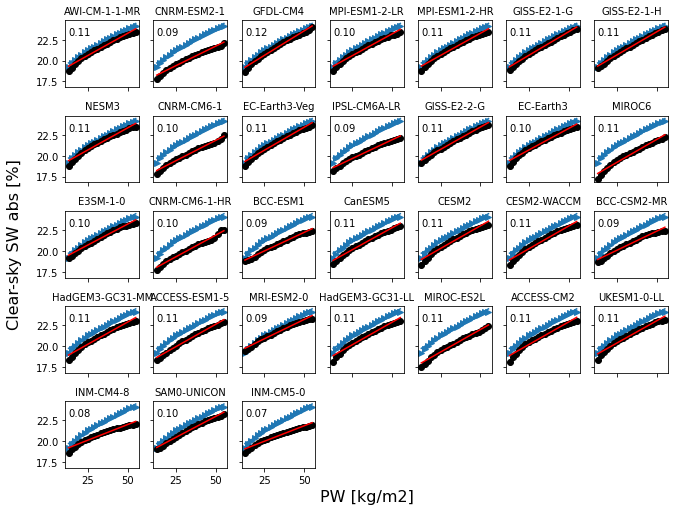

In [128]:
fig = plt.figure(figsize=[10,7.5])
axes =  fig.subplots(5,7,sharex=True,sharey=True)
ind_array=np.reshape(np.arange(35),axes.shape)

mod_slopes = []
for imod,model in enumerate(models_dswadp):
    #variant=models_variants[model][0]
    #modvar = "_".join((model,variant))
    i,j = np.argwhere(ind_array==imod)[0]

    swa_bin=np.array(ds_overlap.swa.isel(model_variant=indexPosList_dswadp[model]).mean("model_variant"))

    axes[i,j].plot(bincenters,new_obs,'>',color="tab:blue")

    for iobs,color in enumerate(["tab:blue"]):
        slope, intercept, r_value, p_value, std_err = stats.linregress(bincenters,new_obs)
        reg_line = (intercept + slope*bincenters)
        axes[i,j].plot(bincenters,reg_line,color=color)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(bincenters,swa_bin)
    reg_line = (intercept + slope*bincenters)
    
    axes[i,j].plot(bincenters,swa_bin,'-ok')
    axes[i,j].plot(bincenters,reg_line,'-r')    
    axes[i,j].set_title(model,fontsize=10)
    
    axes[i,j].text(13,23,"{:0.2f}".format(slope))
    mod_slopes.append([slope,std_err])


for imod in range(31,35):
    i,j = np.argwhere(ind_array==imod)[0]
    axes[i,j].set(visible=False)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("PW [kg/m2]",fontsize=16)
plt.ylabel("Clear-sky SW abs [%]",fontsize=16,labelpad=20)

fig.tight_layout()

In [129]:
dswadpw = np.zeros((len(models),2))*np.nan
#dswa_mods = models_dswadp
for imod,model in enumerate(models):
    #print(imod,model)
    if model in models_dswadp:
        iswp = models_dswadp.index(model)
        dswadpw[imod,:] = mod_slopes[iswp]

In [130]:
## Use DeAngelis et al error bars: top and bottom of confidence range from *all* obs.

In [131]:
obs_conf_int = np.zeros((4,2))
for iobs in range(4):
    obs_conf_int[iobs,0] = obs_slopes[iobs][0]-obs_slopes[iobs][1]*1.96
    obs_conf_int[iobs,1] = obs_slopes[iobs][0]+obs_slopes[iobs][1]*1.96

In [132]:
obs_slope_plot = np.array   ([obs_conf_int[:3,:].min(),obs_slopes[3][0],obs_conf_int[:3,:].max()])

In [133]:
filename = "data/41586_2015_BFnature15770_MOESM56_ESM_panelb.csv" #From DeAngelis et al., 2015 supplementary data

In [134]:
cmip5data = pd.read_csv(filename)

In [135]:
cmip5models = list(cmip5data.iloc[1:26,1])#,4,5,6,8]]

In [136]:
cmip5model_numbers = np.arange(1,26)
for i in range(25):
    print(cmip5model_numbers[i],cmip5models[i])

1 ACCESS1.0
2 ACCESS1.3
3 BCC-CSM1.1
4 BCC-CSM1.1(m)
5 CanESM2
6 CCSM4
7 CNRM-CM5
8 CNRM-CM5-2
9 GFDL-CM3
10 GFDL-ESM2G
11 GFDL-ESM2M
12 GISS-E2-H
13 GISS-E2-R
14 HadGEM2-ES
15 INM-CM4
16 IPSL-CM5A-LR
17 IPSL-CM5A-MR
18 IPSL-CM5B-LR
19 MIROC-ESM
20 MIROC5
21 MPI-ESM-LR
22 MPI-ESM-MR
23 MPI-ESM-P
24 MRI-CGCM3
25 NorESM1-M


In [137]:
cmip5data_vals = np.array(cmip5data.iloc[1:26,[4,5,6,8]],"float")

In [138]:
x = dswadpw[:,0]
xw = dswadpw[:,1]
y = toa_clr[:,0]+sfc_clr[:,0]

mods = np.arange(len(models))+1

mods = mods[~np.isnan(x)]
y = y[~np.isnan(x)]
xw = xw[~np.isnan(x)]
x = x[~np.isnan(x)]


x5 = cmip5data_vals[:,1]
xm5 = cmip5data_vals[:,0]
xp5 = cmip5data_vals[:,2]

y5 = -cmip5data_vals[:,3]

In [139]:
obs = np.array([29.7,35.5])

In [140]:
mods = np.arange(len(models))+1

In [141]:
i = np.linspace(.5,0,33)

In [142]:
greens = np.vstack([i,i+.5,i])

## Figure 1

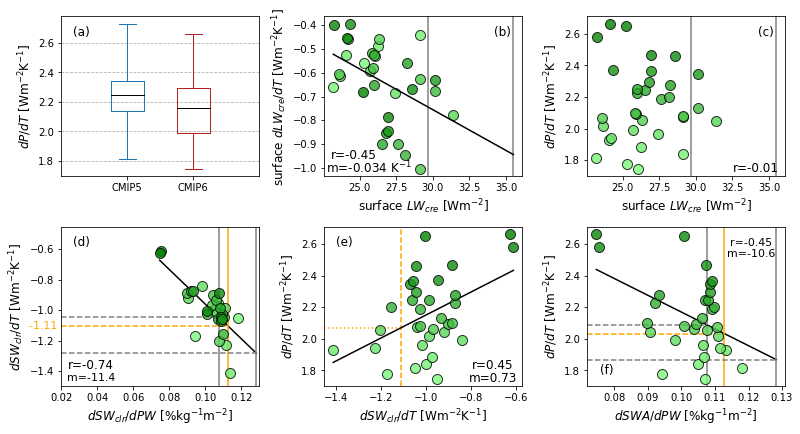

In [143]:
# Create a figure
fig = plt.figure(figsize=(19/2.54*3/2, 6))


ax = fig.add_subplot(2,3,1)


ax1 = ax.boxplot(dpdt_abs_5_def2,meanline=True,showmeans=True,whis='range',positions=[1],labels=['CMIP5'],widths=.5)
for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
    plt.setp(ax1[element], color='tab:blue')
plt.setp(ax1['fliers'], markeredgecolor='tab:blue')
plt.setp(ax1['means'], linestyle="-", color='k')
plt.setp(ax1['medians'], linestyle="none", color='none')

ax2 = ax.boxplot(dp_abs,meanline=True,showmeans=True,whis='range',positions=[2],labels=['CMIP6'],widths=.5)
for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
    plt.setp(ax2[element], color='firebrick')
plt.setp(ax2['fliers'], markeredgecolor='firebrick')
plt.setp(ax2['means'], linestyle="-", color='k')
plt.setp(ax2['medians'], linestyle="none", color='none')

#data=[dpdt_abs_5_def2,dp_abs]
# ax1 = plt.boxplot(data,meanline=True,whis=[5, 95],labels=['CMIP5','CMIP6']) #,showfliers=False
# plt.plot([0,3],[0,0],color='grey',linewidth=1)
plt.xlim([0,3])
#plt.plot([.5,2.5],[0,0],color='grey',linewidth=1)
plt.grid(axis="y",linestyle="--")
# plt.title('(a)')
plt.ylabel('$dP/dT$ [Wm$^{-2}$K$^{-1}$]',fontdict={'size':12})
# ax.set_ylabel('Relative HS [%K$^{-1}$]')
# ax.set_title('(b)')


ax.text(0.1, 0.9,'(a)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})


ax = fig.add_subplot(2,3,2)


y = sfc_cre[:,1]
x = sfc_cre_lw_pi
#title = "Watanabe Fig 6a"

# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10) #ax.set_ylabel('$\lambda$ [W/m2/K]', fontdict={'size':16}) #ax.set_xlabel('$\lambda_{SW,cre}$ [W/m2/K]', fontdict={'size':16}) ax.set_title(title, fontdict={'size':16})
ax.set_ylabel('surface $dLW_{cre}/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_xlabel('surface $LW_{cre}$ [Wm$^{-2}$]', fontdict={'size':12})

for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)




yl=ax.get_ylim()
ax.plot([obs[0],obs[0]],yl,color='grey')
ax.plot([obs[1],obs[1]],yl,color='grey')
ax.set_ylim(yl)


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),obs.max(),num=50)
regy = (intercept + slope*regx)

ax.plot(regx,regy,'k')

ax.text(0.01, 0.05,'m='+str("%2.3f" % slope)+' K$^{-1}$', 
        ha='left', va='center', transform=ax.transAxes, 
        fontdict={'size':12})#,color="C0")

ax.text(0.15, 0.13,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

# ax.text(0.9, 0.9,'(f)',
#         ha='center', va='center', transform=ax.transAxes,
#         fontdict={'size':12})


# ax.text(0.1, 0.9,'(g)',
#         ha='center', va='center', transform=ax.transAxes,
#         fontdict={'size':12})

ax.text(0.9, 0.9,'(b)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})




ax = fig.add_subplot(2,3,3)


y = dp_abs
x = sfc_cre_lw_pi
#title = "Watanabe Fig 6a"

# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10) #ax.set_ylabel('$\lambda$ [W/m2/K]', fontdict={'size':16}) #ax.set_xlabel('$\lambda_{SW,cre}$ [W/m2/K]', fontdict={'size':16}) ax.set_title(title, fontdict={'size':16})
ax.set_ylabel('$dP/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_xlabel('surface $LW_{cre}$ [Wm$^{-2}$]', fontdict={'size':12})

for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)




yl=ax.get_ylim()
ax.plot([obs[0],obs[0]],yl,color='grey')
ax.plot([obs[1],obs[1]],yl,color='grey')
ax.set_ylim(yl)


# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# regx = np.linspace(x.min(),obs.max(),num=50)
# regy = (intercept + slope*regx)

# ax.plot(regx,regy,'k')


ax.text(0.85, 0.05,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

# ax.text(0.9, 0.9,'(f)',
#         ha='center', va='center', transform=ax.transAxes,
#         fontdict={'size':12})


# ax.text(0.1, 0.9,'(g)',
#         ha='center', va='center', transform=ax.transAxes,
#         fontdict={'size':12})


ax.text(0.9, 0.9,'(c)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})


ax = fig.add_subplot(2,3,4)



x = dswadpw[:,0]
y = toa_clr[:,0]+sfc_clr[:,0]
mods = np.arange(len(models))
mods = mods[~np.isnan(x)]
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

ax.plot(x,y,linestyle='None',markersize=10)
ax.set_xlabel('$dSW_{clr}/dPW$ [%kg$^{-1}$m$^{-2}$]', fontdict={'size':12})
ax.set_ylabel('$dSW_{clr}/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
#ax.set_title(title, fontdict={'size':16})


# for iobs,color in enumerate(["green","blue","purple"]):
#     ax.plot([obs_slopes[iobs][0],obs_slopes[iobs][0]],[y.min(),y.max()],color=color)
#     ax.plot([x.min(),obs_slopes[iobs][0]],[intercept+slope*obs_slopes[iobs][0],intercept+slope*obs_slopes[iobs][0]],'--',color=color)

#         fontdict={'size':12})
ax.plot(x5,y5,marker='o',linestyle='None',color='none',markerfacecolor="none",markersize=10,alpha=0.8)
ax.plot(x,y,marker='o',linestyle='None',color='none',markerfacecolor="none",markersize=10,alpha=0.8)


ax.set_xlim([.02,.13])
ax.set_ylim([-1.5,-.45])

xl=ax.get_xlim()


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),obs_slope_plot[2],num=50)
regy = (intercept + slope*regx)


# ax.plot([x.min(),x.max()],[-1.1,-1.1],color='m')
for iobs,color in enumerate(["grey","orange","grey"]):
    ax.plot([obs_slope_plot[iobs],obs_slope_plot[iobs]],[-1.5,-.45],color=color)
    ax.plot([xl[0],obs_slope_plot[iobs]],[intercept+slope*obs_slope_plot[iobs],intercept+slope*obs_slope_plot[iobs]],'--',color=color)



ax.plot(regx,regy,'k',zorder=0)

# ax.plot(x5,y5,marker='o',linestyle='None',color='lightgrey',markerfacecolor="grey",markersize=10,alpha=0.8)
#ax.plot(x,y,marker='o',linestyle='None',color='lightgrey',markerfacecolor="firebrick",markersize=10,alpha=0.8)

for imod,jmod in enumerate(mods):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,jmod],markersize=10,alpha=0.8)



ax.text(xl[0], intercept+slope*obs_slope_plot[1],"{:2.2f} ".format(intercept+slope*obs_slope_plot[1]), 
        ha='right', va='center', 
        fontdict={'size':11},color="orange")


ax.text(0.15, 0.05,'m='+str("%2.1f" % slope), 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'size':11})#,color="C0")

ax.text(0.15, 0.13,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

ax.text(0.1, 0.9,'(d)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

ax = fig.add_subplot(2,3,5)

y = dp_abs
x = toa_clr[:,0]+sfc_clr[:,0]
#title = "$\Delta P/\Delta T$ and clr-$\Delta SWa/\Delta T$ [DeAngelis et al 2015ED F7b]"
# Create a figure
# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10)
ax.set_ylabel('$dP/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_xlabel('$dSW_{clr}/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
#ax.set_title(title, fontdict={'size':16})


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),x.max(),num=50)
regy = (intercept + slope*regx)

ax.plot(regx,regy,'k')


for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)



ax.text(0.85, 0.05,'m='+str("%2.2f" % slope), 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'size':12})#,color="C0")

ax.text(0.85, 0.13,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

yl=ax.get_ylim()
xl=ax.get_xlim()
ax.plot([-1.11,-1.11],yl,'--',color='orange',zorder=0)
ax.plot([xl[0],-1.11],[intercept+slope*(-1.11),intercept+slope*(-1.11)],':',color='orange',zorder=0)

ax.set_ylim(yl)
ax.set_xlim(xl)


# ax.text(0.1, 0.9,'(e)',
#         ha='center', va='center', transform=ax.transAxes,
#         fontdict={'size':12})


ax.text(0.1, 0.9,'(e)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

ax = fig.add_subplot(2,3,6)


x = dswadpw[:,0]
y = dp_abs


y = y[~np.isnan(x)]
x = x[~np.isnan(x)]


ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10)
ax.set_ylabel('$dP/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_xlabel('$dSWA/dPW$ [%kg$^{-1}$m$^{-2}$]', fontdict={'size':12})
#ax.set_title(title, fontdict={'size':16})


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),obs_slope_plot[2],num=50)
regy = (intercept + slope*regx)



for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)


ax.plot(regx,regy,'k',zorder=0)

ax.text(0.825, 0.83,'m='+str("%2.1f" % slope), 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'size':11})#,color="C0")


yl=ax.get_ylim()
xl=ax.get_xlim()

for iobs,color in enumerate(["grey","orange","grey"]):
    ax.plot([obs_slope_plot[iobs],obs_slope_plot[iobs]],[yl[0],yl[1]],color=color,zorder=0)
    ax.plot([xl[0],obs_slope_plot[iobs]],[intercept+slope*obs_slope_plot[iobs],intercept+slope*obs_slope_plot[iobs]],'--',color=color,zorder=0)

ax.set_ylim(yl)
ax.set_xlim(xl)

ax.text(0.825, 0.9,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':11})



ax.text(0.1, 0.1,'(f)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

plt.tight_layout()

## Figure 2

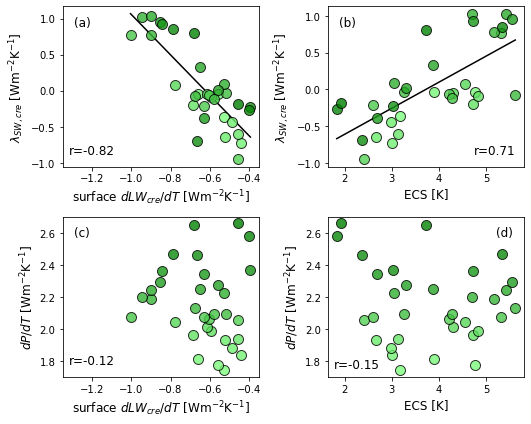

In [144]:
fig = plt.figure(figsize=(19/2.54, 6))

ax = fig.add_subplot(2,2,1)

x = sfc_cre[:,1]
y = -toa_cre[:,0]


# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10)
ax.set_xlabel('surface $dLW_{cre}/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_ylabel('$\lambda_{SW,cre}$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
#ax.set_title(title, fontdict={'size':16})

ax.set_xlim([-1.35,-.35])


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),x.max(),num=50)
regy = (intercept + slope*regx)

ax.plot(regx,regy,'k')

# ax.text(0.15, 0.15,'m='+str("%2.2f" % slope), 
#         ha='center', va='bottom', transform=ax.transAxes, 
#         fontdict={'size':12})#,color="C0")


for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)



ax.text(0.15, 0.1,'r='+str(round(np.corrcoef(x,y)[1,0],2)), 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'size':12})



ax.text(0.1, 0.9,'(a)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})



ax = fig.add_subplot(2,2,3)


x = sfc_cre[:,1]
y = dp_abs


# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10)
ax.set_ylabel('$dP/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_xlabel('surface $dLW_{cre}/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
#ax.set_title(title, fontdict={'size':16})

for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)

ax.set_ylim([1.7,2.7])
ax.set_xlim([-1.35,-.35])

#ax.set_xlim([-.515,.485])

ax.text(0.15, 0.1,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})

ax.text(0.1, 0.9,'(c)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})



ax = fig.add_subplot(2,2,2)


x = ecs/2
y = -toa_cre[:,0]




# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10)
ax.set_xlabel('ECS [K]', fontdict={'size':12})
ax.set_ylabel('$\lambda_{SW,cre}$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
#ax.set_title(title, fontdict={'size':16})


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),x.max(),num=50)
regy = (intercept + slope*regx)

ax.plot(regx,regy,'k')

for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)


# ax.set_ylim([-1.575,-.575])
# ax.set_xlim([-.5,.5])


ax.text(0.85, 0.1,'r='+str(round(np.corrcoef(x,y)[1,0],2)), 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'size':12})

ax.text(0.1, 0.9,'(b)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})




ax = fig.add_subplot(2,2,4)




x = ecs/2
y = dp_abs


# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='none',markersize=10)
ax.set_ylabel('$dP/dT$ [Wm$^{-2}$K$^{-1}$]', fontdict={'size':12})
ax.set_xlabel('ECS [K]', fontdict={'size':12})

for imod in range(len(x)):
    #ax.text(x[imod], y[imod],"{:d}".format(mods[imod]), ha='center', va='center',  color="k",fontdict={'size':8})
    ax.plot(x[imod], y[imod],marker='o',linestyle='None',color='k',markerfacecolor=greens[:,imod],markersize=10,alpha=0.8)

ax.set_ylim([1.7,2.7])


#ax.text(0.85, 0.1,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
#ax.text(0.85, 0.9,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
ax.text(0.15, 0.075,'r='+str(round(np.corrcoef(x,y)[1,0],2)),
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})



ax.text(0.9, 0.9,'(d)',
        ha='center', va='center', transform=ax.transAxes,
        fontdict={'size':12})


plt.tight_layout()

### Constraining HS: CMIP6, also repeat CMIP5

In [156]:
y = dp_abs
x = toa_clr[:,0]+sfc_clr[:,0]


In [157]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),x.max(),num=50)
regy = (intercept + slope*regx)

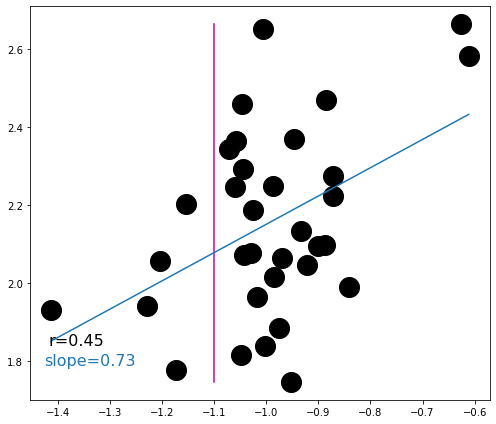

In [158]:

# Create a figure
fig = plt.figure(figsize=(7, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(x,y,marker='o',linestyle='None',color='k',markersize=20)
#ax.set_ylabel('$\Delta P/\Delta T$ [W/m2/K]', fontdict={'size':16})
#ax.set_xlabel('atmosphere $\Delta R_{LW}/\Delta T$ [W/m2/K]', fontdict={'size':16})

ax.plot([-1.1,-1.1],[y.min(),y.max()],color='m')


ax.plot(regx,regy)

ax.text(0.1, 0.15,'r='+str(round(np.corrcoef(x,y)[1,0],2)), 
        ha='center', va='center', transform=ax.transAxes, 
        fontdict={'size':16})


ax.text(0.03, 0.1,'slope='+str("%2.2f" % slope), 
        ha='left', va='center', transform=ax.transAxes, 
        fontdict={'size':16},color="C0")

plt.tight_layout()

In [159]:
dpdt_model_reg  = (intercept + slope*x)

In [160]:
dpdt_true = (intercept + slope*(-1.1))

In [161]:
dpdt_bias = dpdt_model_reg - dpdt_true


In [162]:
dpdt_abs_dcorr_d6 = dp_abs - dpdt_bias

In [163]:
'CMIP6 dSWclr/dT-constrained absolute HS mean: {:2.1f}  ({:2.0f}%)'.format(dpdt_abs_dcorr_d6.mean(),100-dpdt_abs_dcorr_d6.mean()/dp_abs.mean()*100)

'CMIP6 dSWclr/dT-constrained absolute HS mean: 2.1  ( 4%)'

In [164]:
'CMIP6 dSWclr/dT-constrained absolute HS spread: {:2.2f}  ({:2.0f}%)'.format(dpdt_abs_dcorr_d6.std(),100-dpdt_abs_dcorr_d6.std()/dp_abs.std()*100)

'CMIP6 dSWclr/dT-constrained absolute HS spread: 0.21  (11%)'

### DeAngelis constraint for CMIP5 (for comparison)

In [165]:
y = dpdt_abs_5_def2
x = -clr_dSWAdT_5_def2


In [166]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
regx = np.linspace(x.min(),x.max(),num=50)
regy = (intercept + slope*regx)

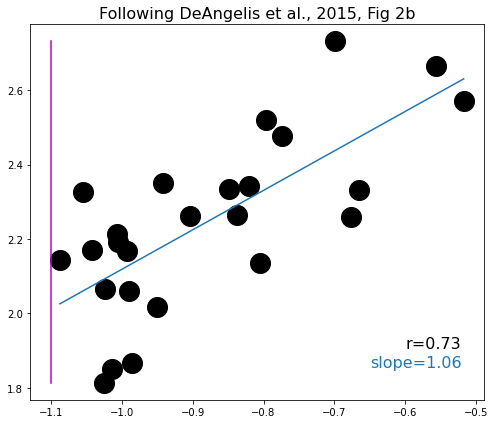

In [169]:
fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(1, 1, 1)

ax.plot(x,y,marker='o',linestyle='None',color='k',markersize=20)

ax.set_title("Following DeAngelis et al., 2015, Fig 2b", fontdict={'size':16})

ax.plot([-1.1,-1.1],[y.min(),y.max()],color='m')



ax.plot(regx,regy)

ax.text(0.95, 0.15,'r='+str(round(np.corrcoef(x,y)[1,0],2)), 
        ha='right', va='center', transform=ax.transAxes, 
        fontdict={'size':16})


ax.text(0.95, 0.1,'slope='+str("%2.2f" % slope), 
        ha='right', va='center', transform=ax.transAxes, 
        fontdict={'size':16},color="C0")

plt.tight_layout()


In [170]:
dpdt_model_reg  = (intercept + slope*x)

In [171]:
dpdt_true = (intercept + slope*(-1.1))

In [172]:
dpdt_bias = dpdt_model_reg - dpdt_true


In [173]:
dpdt_abs_dcorr_d5 = dpdt_abs_5_def2 - dpdt_bias

In [174]:
'CMIP5 DeAngelis-constrained absolute HS mean: {:2.1f}  ({:2.0f}%)'.format(dpdt_abs_dcorr_d5.mean(),100-dpdt_abs_dcorr_d5.mean()/dpdt_abs_5_def2.mean()*100)


'CMIP5 DeAngelis-constrained absolute HS mean: 2.0  (10%)'

In [175]:
'CMIP5 DeAngelis-constrained absolute HS spread: {:2.2f}  ({:2.0f}%)'.format(dpdt_abs_dcorr_d5.std(),100-dpdt_abs_dcorr_d5.std()/dpdt_abs_5_def2.std()*100)


'CMIP5 DeAngelis-constrained absolute HS spread: 0.16  (31%)'